In [138]:
from torch_geometric.datasets import Entities
import os.path as osp
import networkx as nx
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch_geometric as pyg

import numpy as np

from src import network_generator as ng

from src import GraphNeuralNet

from src import DataSetup

In [2]:
name = 'MUTAG'
path = osp.join('.', '..', 'data', 'Entities', name)
dataset = Entities(path, name)
data = dataset[0]

In [13]:
data.edge_type.shape

torch.Size([148454])

In [15]:
from src import DataSetup

In [17]:
train, val, test = DataSetup.TrainTestSplit(data, 0.1, 0.1, neg_samples=True)

In [260]:
def draw(G, pos, size, measures, measure_name):
    
    fig = plt.figure(figsize=(12,10))
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=size, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.figaspect(8)
    plt.show()

In [257]:
G_nx = nx.barabasi_albert_graph(1000, m=6)

#G_nx, G = ng.generatePSNetwork_nx(N=50, avg_k=2, gamma=2.4, Temp=0.1, seed=0)
G_nx.graph['pos'] = nx.spring_layout(G_nx)

In [264]:
G_nx.degree()

DegreeView({0: 106, 1: 90, 2: 67, 3: 26, 4: 19, 5: 31, 6: 46, 7: 115, 8: 91, 9: 57, 10: 65, 11: 97, 12: 76, 13: 88, 14: 73, 15: 36, 16: 84, 17: 60, 18: 73, 19: 59, 20: 61, 21: 45, 22: 56, 23: 34, 24: 23, 25: 53, 26: 25, 27: 21, 28: 45, 29: 46, 30: 33, 31: 59, 32: 37, 33: 48, 34: 32, 35: 30, 36: 27, 37: 25, 38: 25, 39: 27, 40: 31, 41: 26, 42: 27, 43: 26, 44: 15, 45: 22, 46: 30, 47: 35, 48: 30, 49: 29, 50: 29, 51: 23, 52: 42, 53: 20, 54: 14, 55: 16, 56: 22, 57: 27, 58: 25, 59: 13, 60: 23, 61: 17, 62: 12, 63: 24, 64: 50, 65: 37, 66: 20, 67: 26, 68: 38, 69: 26, 70: 25, 71: 34, 72: 23, 73: 22, 74: 17, 75: 33, 76: 18, 77: 26, 78: 27, 79: 15, 80: 33, 81: 15, 82: 24, 83: 15, 84: 25, 85: 34, 86: 22, 87: 26, 88: 20, 89: 19, 90: 17, 91: 17, 92: 38, 93: 14, 94: 34, 95: 28, 96: 11, 97: 15, 98: 22, 99: 26, 100: 22, 101: 12, 102: 18, 103: 14, 104: 25, 105: 17, 106: 11, 107: 15, 108: 25, 109: 14, 110: 10, 111: 9, 112: 14, 113: 10, 114: 17, 115: 22, 116: 14, 117: 17, 118: 26, 119: 23, 120: 22, 121: 27,

In [262]:
G_nx.graph['size'] = G_nx.degree()

ValueError: s must be a scalar, or float array-like with the same size as x and y

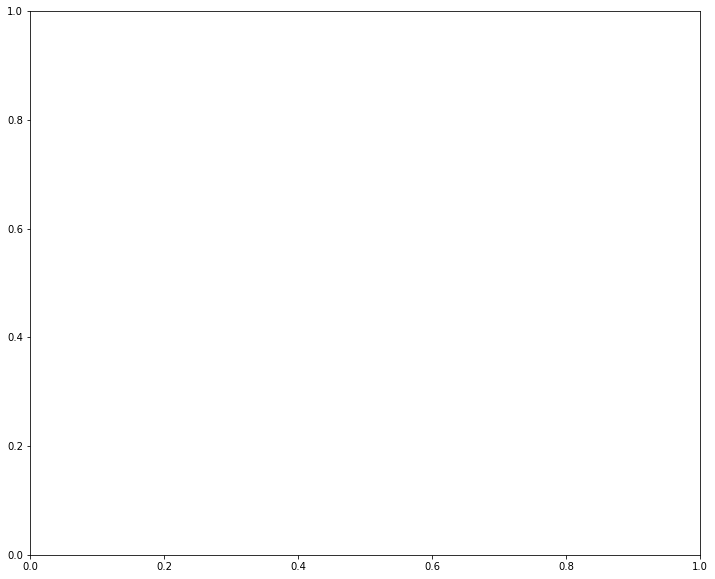

In [263]:
draw(G_nx, G_nx.graph['pos'], G_nx.graph['size'], nx.degree_centrality(G_nx), 'Degree Centrality')

In [228]:
data = pyg.utils.from_networkx(G_nx)
#data.x = torch.Tensor( np.transpose([list(nx.degree_centrality(G_nx).values())]) )
data.x = torch.diag(torch.ones(G_nx.number_of_nodes()))

train, val, test = DataSetup.TrainTestSplit(data, test_ratio=0, val_ratio=0, neg_samples=True)

In [246]:
graphSage = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=32, out_channels=data.num_features, num_layers=3)
optimizer = torch.optim.SGD(graphSage.parameters(), lr=0.01)

In [247]:
def decode(z, pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    return logits

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] where the number of ones is equal to the length of 
    # pos_edge_index and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [248]:
device = 'cpu'

In [249]:
for i in range(1):
    graphSage.train()
    optimizer.zero_grad()

    z = graphSage.forward(train.x, train.pos_edge_label_index) #forward
    link_logits = decode(z, train.pos_edge_label_index, train.neg_edge_label_index) # decode

    link_labels = get_link_labels(train.pos_edge_label_index, train.neg_edge_label_index)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(link_logits, link_labels)
    #probs = z @ z.T
    #probs = nn.functional.normalize(torch.concat((probs[train_data.pos_edge_label_index[0], train_data.pos_edge_label_index[1]],
                                                    #probs[train_data.neg_edge_label_index[0], train_data.neg_edge_label_index[1]])), dim=0)
    #loss = nn.functional.binary_cross_entropy(probs, link_labels)
    loss.backward()
    optimizer.step()

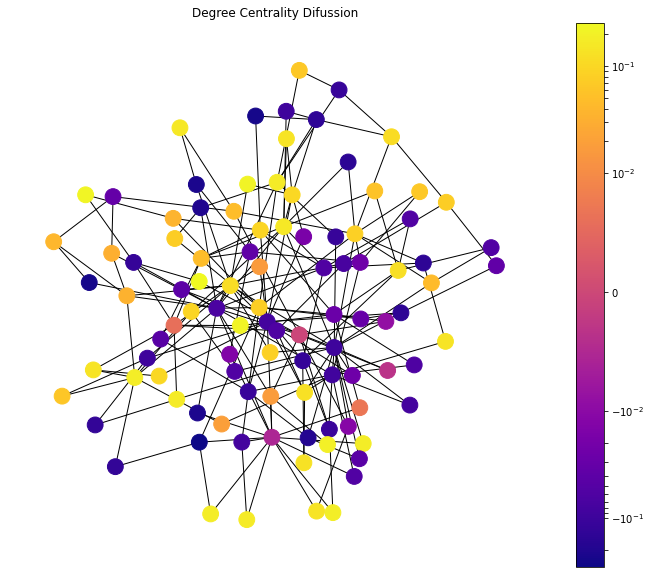

In [250]:
draw(G_nx, G_nx.graph['pos'], tensorToNodeDict(z), 'Degree Centrality Difussion')

In [237]:
def tensorToNodeDict(z):
    _ = {}
    for i in range(G_nx.number_of_nodes()):
        _[i] = float(z[i,i])
    return _

In [160]:
tensorToNodeDict(z)

{0: 0.16673123836517334,
 1: 0.41177231073379517,
 2: 0.3968850374221802,
 3: 0.40555432438850403,
 4: 0.41786038875579834,
 5: 0.41565078496932983,
 6: 0.4247881770133972,
 7: 0.39829784631729126,
 8: 0.38899901509284973,
 9: 0.4267875552177429,
 10: 0.40541180968284607,
 11: 0.41092008352279663,
 12: 0.4263686537742615,
 13: 0.40921151638031006,
 14: 0.4140985906124115,
 15: 0.39816856384277344,
 16: 0.4164626896381378,
 17: 0.42305976152420044,
 18: 0.39816856384277344,
 19: 0.4357054829597473,
 20: 0.4169034957885742,
 21: 0.4334144592285156,
 22: 0.431877076625824,
 23: 0.40340062975883484,
 24: 0.4130207300186157,
 25: 0.4343174397945404,
 26: 0.4340618848800659,
 27: 0.41846635937690735,
 28: 0.41715699434280396,
 29: 0.419061541557312,
 30: 0.41850900650024414,
 31: 0.43966221809387207,
 32: 0.4005071520805359,
 33: 0.4344600439071655,
 34: 0.43543702363967896,
 35: 0.4185907244682312,
 36: 0.41552475094795227,
 37: 0.42355090379714966,
 38: 0.43051058053970337,
 39: 0.41728329